In [1]:
import pathlib
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import seaborn as sns
import time
import cmocean
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import scipy.signal
import copy

## (optional) remove gridlines from plots
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

In [2]:
# helper plot and load functions

def plot_setup_PNW(fig):
    proj = ccrs.Orthographic(central_longitude=-135, central_latitude=45)
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    # Show NE Pacific
    ax.set_extent([-170, -100, 15, 70], crs=ccrs.PlateCarree())

    # coastlines/grid
    ax.coastlines(resolution="110m")
    gl = ax.gridlines(draw_labels=False, linestyle="--", color = 'gray',linewidth=0.5, alpha=0.4)
    return fig, ax

def load_era5_from_cloud(lon_range, lat_range):
    """Load ERA5 from Google server"""

    ## open data and get SST
    data = xr.open_zarr(
        "gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr",
        chunks=dict(time=1024),
    )["sea_surface_temperature"]

    ## subset for lon/lat range
    lonlat_idx = dict(longitude=slice(*lon_range), latitude=slice(*lat_range))
    data = data.sel(**lonlat_idx)

    ## load into memory
    data.load()

    ## resample from 6-hourly to monthly
    data = data.resample({"time": "MS"}).mean()

    ## transpose data (consistent with data on server)
    data = data.transpose("time", "latitude", "longitude")

    return data

In [3]:
## specify lon/lat range
KWARGS = dict(lon_range=[190, 260], lat_range=[15, 70])

## keep track of time for data loading
t0 = time.time()

da = load_era5_from_cloud(**KWARGS)

## print elapsed time
print(f"{time.time() - t0: .1f} seconds")

 49.0 seconds


In [4]:
da

<xarray.DataArray 'sea_surface_temperature' (time: 769, latitude: 36,
                                             longitude: 47)> Size: 5MB
array([[[298.98148, 298.88647, 298.71582, ..., 301.32758, 301.6175 ,
               nan],
        [298.5858 , 298.58237, 298.56696, ...,       nan,       nan,
               nan],
        [298.05905, 298.07996, 298.08112, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [271.4601 , 271.4601 ,       nan, ...,       nan,       nan,
               nan],
        [271.4601 , 271.4601 ,       nan, ...,       nan,       nan,
               nan]],

       [[298.43747, 298.19327, 297.93213, ..., 301.47186, 301.72272,
               nan],
        [298.02496, 297.94733, 297.82758, ...,       nan,       nan,
               nan],
        [297.63284, 297.55225, 297.51227, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [271.80664, 271.89587,       nan, ...,       nan,       nan,
               nan],
        [271.52765, 271.61203,       nan, ...,       nan,       nan,
               nan]],

       [[299.73257, 299.63046, 299.535  , ..., 301.61646, 301.88544,
               nan],
        [299.66895, 299.62595, 299.5822 , ...,       nan,       nan,
               nan],
        [299.31204, 298.98315, 299.36786, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [271.46017, 271.46017,       nan, ...,       nan,       nan,
               nan],
        [271.46014, 271.46017,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 288B 16.5 18.0 19.5 21.0 ... 66.0 67.5 69.0
  * longitude  (longitude) float64 376B 190.5 192.0 193.5 ... 256.5 258.0 259.5
  * time       (time) datetime64[ns] 6kB 1959-01-01 1959-02-01 ... 2023-01-01
Attributes:
    long_name:   Sea surface temperature
    short_name:  sst
    units:       K

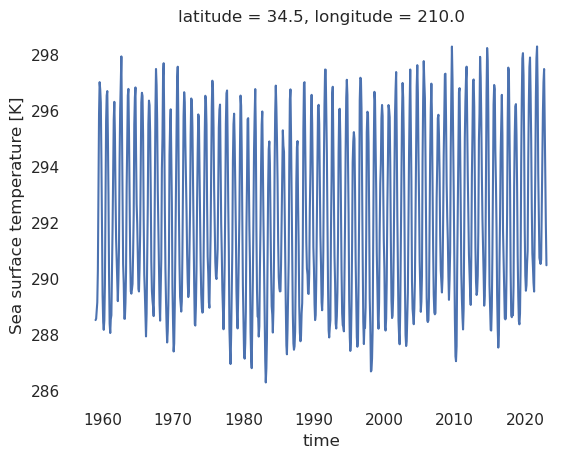

In [5]:
# time series at a point
ts = da.sel(latitude=35, longitude=210, method="nearest")
ts.plot()

#yearly average ssts across the entire spatial doman
#Taking advantage of ability to resample and mean function
# da["celsius"] = da - 273.15

# ts = da.celsius.resample(time="YE").mean(dim=["time", "latitude", "longitude"])
# ts.plot()

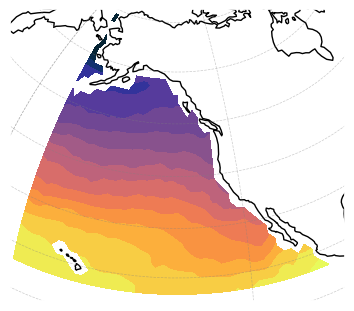

In [6]:
# basic plot w built in matplotlib compatability
#da.sel(time="2000-01-01").plot(x="longitude", y="latitude")

#our plotting function which adds cartopy features
fig = plt.figure(layout="constrained", figsize=(5, 3))
fig, ax = plot_setup_PNW(fig)

plot_data = ax.contourf(
    da.longitude,          
    da.latitude,            
    da.isel(time=-1),       
    transform=ccrs.PlateCarree(),
    levels=15,
    extend="both",
    cmap=cmocean.cm.thermal,  
)

plt.show()

In [7]:
def spatial_avg(data):
    """function to compute spatial average of data on grid with constant
    longitude/latitude spacing."""

    ## first, compute cosine of latitude (after converting degrees to radians)
    latitude_radians = np.deg2rad(data.latitude)
    cos_lat = np.cos(latitude_radians)

    ## get weighted average using xarray
    avg = data.weighted(weights=cos_lat).mean(["longitude", "latitude"])

    return avg


def get_trend(data, dim="time", deg=1):
    """
    Get trend for an xr.dataarray along specified dimension,
    by fitting polynomial of degree 'deg'.
    """

    ## Get coefficients for best fit
    polyfit_coefs = data.polyfit(dim=dim, deg=deg)["polyfit_coefficients"]

    ## Get best fit line (linear trend in this case)
    trend = xr.polyval(data[dim], polyfit_coefs)

    return trend


def detrend(data, dim="time", deg=1):
    """
    Remove trend of degree 'deg' from data, along dimension 'dim'.
    """

    return data - get_trend(data, dim=dim, deg=deg)

In [ ]:
def compute_T_wh(x):
    """Compute  temperature index"""

    ## define lon/lat range for averaging
    ## (note latitude is in descending order in ERA5)
    # region = dict(latitude=slice(44, 39), longitude=slice(-72.5, -66.5))
    region = dict(latitude=slice(39, 44), longitude=slice(287.5, 293.5))

    ## get subset of data inside the box
    data_subset = x.sel(region)

    ## compute spatial average
    return spatial_avg(data_subset)


## do the computation here
idx = compute_T_wh(data)

In [9]:
# lets compute a "tempertature index"
## define lon/lat range for averaging (note latitude is in descending order in ERA5)

region = dict(latitude=slice(49, 47), longitude=slice(236, 238))

## get subset of data inside the box
data_subset = da.sel(region)

## compute spatial average
spatial_avg(data_subset)

<xarray.DataArray 'sea_surface_temperature' (time: 769)> Size: 6kB
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
...
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 6kB 1959-01-01 1959-02-01 ... 2023-01-01

In [12]:
## compute anomalies at gridpoint level, then recompute temperature index
data_anom = da.groupby("time.month") - da.groupby("time.month").mean()
idx_anom = compute_T_wh(data_anom).compute()

## compute linear trend (set deg=2 for quadratic trend)
idx_trend = get_trend(idx_anom, deg=1)

NameError: name 'compute_T_wh' is not defined

In [10]:
## compute correlation (detrend data first)
corr = xr.corr(detrend(data_anom), detrend(idx_anom), dim="time")

## Make plot
fig, ax = plot_correlation(
    plot_setup_fn=plot_setup_atlantic, corr=corr, x=corr.longitude, y=corr.latitude
)

## Mark Woods Hole on map
ax.scatter(
    288.5, 41.5, transform=ccrs.PlateCarree(), marker="*", c="magenta", s=50, zorder=10
)

## label
ax.set_title(r"Correlation with $T_{wh}$")

## save to file
# fig.savefig("figs/spatial-correlation.svg")

plt.show()

NameError: name 'data_anom' is not defined